# A notebook providing sentiment analysis of 2015 US Airline tweets. 
## Dataset used: Tweets.csv

In [0]:
# Necessary imports.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## 1. Cleaning the data

In [0]:
# A look into the data.


print("Shape of the dataframe is", df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [0]:
# Check for null value proportions.


print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [0]:
# (tweet_coord , airline_sentiment_gold, negativereason_gold) have more than 90% missing data. 
# We can safely delete them.


del df["tweet_coord"]
del df["airline_sentiment_gold"]
del df["negativereason_gold"]
del df["name"]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## 2. Pre-classification analysis

Total number of tweets for each airline 

  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64



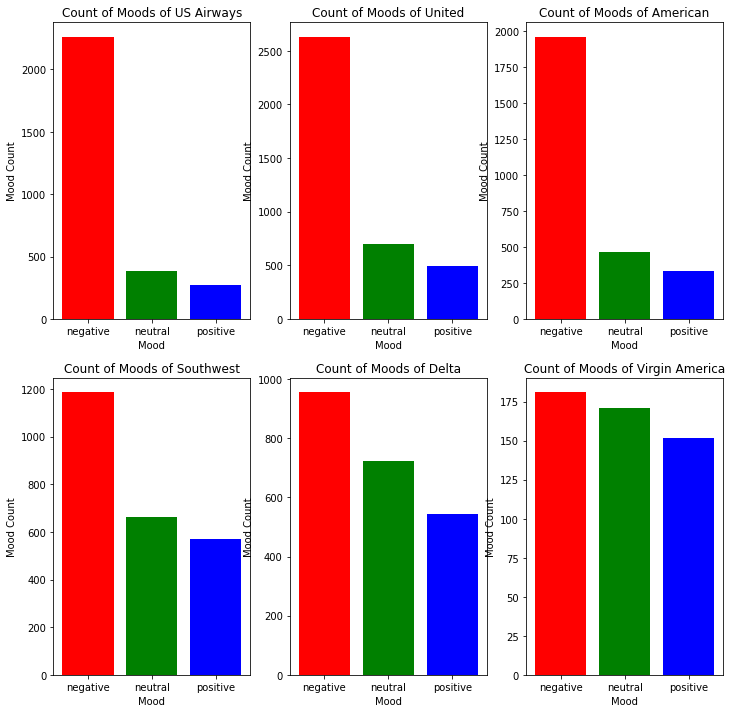

In [0]:
# Calculate the total number of tweets for each airline.
# Get the barplots for each airline with respect to sentiments of tweets (positive,negative or neutral).


print("Total number of tweets for each airline \n\n ", 
      df.groupby("airline")["airline_sentiment"].count().sort_values(ascending=False))
airlines= ["US Airways", "United", "American", "Southwest", "Delta", "Virgin America"]
plt.figure(1, figsize=(12, 12))
print()

for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices+1)
    new_df = df[df["airline"] == i]
    count = new_df["airline_sentiment"].value_counts()
    Index = [1, 2, 3]
    plt.bar(Index, count, color=["red", "green", "blue"])
    plt.xticks(Index,["negative", "neutral", "positive"])
    plt.ylabel("Mood Count")
    plt.xlabel("Mood")
    plt.title("Count of Moods of " + i)

In [0]:
print(df["airline"])

0        Virgin America
1        Virgin America
2        Virgin America
3        Virgin America
4        Virgin America
              ...      
14635          American
14636          American
14637          American
14638          American
14639          American
Name: airline, Length: 14640, dtype: object


**Analysis:** 
United, US Airways, American substantially get negative reactions.
Tweets for Virgin America are the most balanced. 


#### 2.1 Worldclouds to get a visual insight

In [0]:
from wordcloud import WordCloud, STOPWORDS

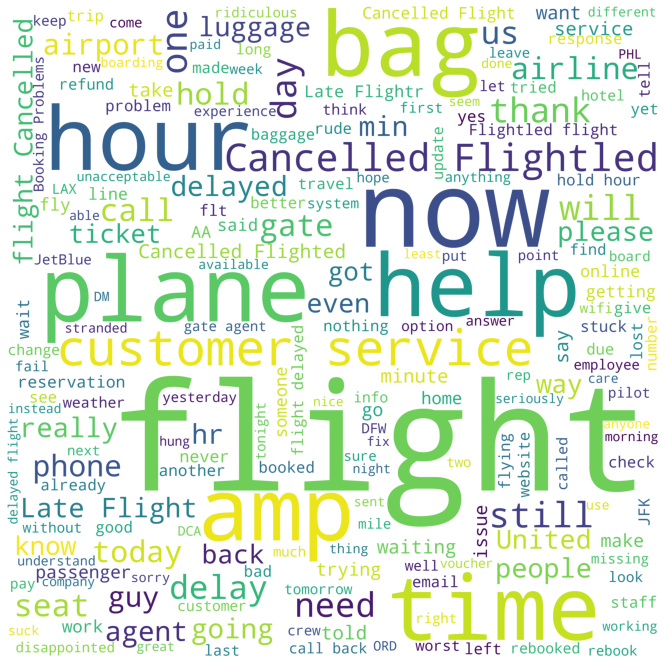

In [0]:
# Wordcloud for Negative sentiments of tweets


new_df = df[df["airline_sentiment"] == "negative"]
words = " ".join(new_df["text"])

# clean words: check if it is not a link, a username or a retweet
cleaned_word = " ".join([word for word in words.split()
                            if "http" not in word
                                and not word.startswith("@")
                                and word != "RT"
                        ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="white",
                      width=3000,
                      height=3000
                     ).generate(cleaned_word)

plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

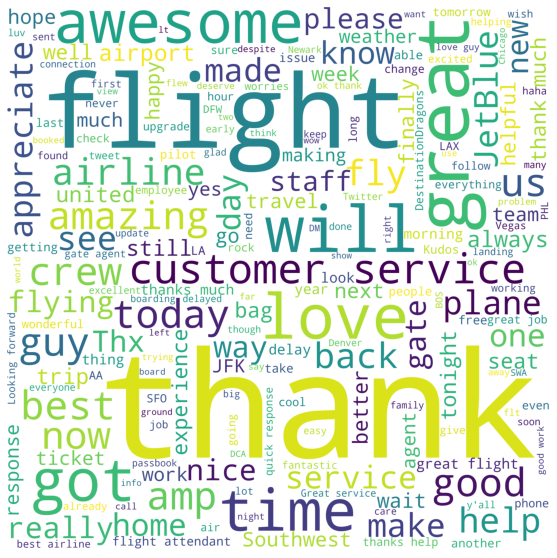

In [0]:
# Repeat the steps for positive sentiment


new_df = df[df["airline_sentiment"] == "positive"]
words = " ".join(new_df["text"])

cleaned_word = " ".join([word for word in words.split()
                            if "http" not in word
                                and not word.startswith("@")
                                and word != "RT"
                        ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color="white",
                      width=3000,
                      height=3000
                     ).generate(cleaned_word)

plt.figure(1, figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 2.2 Word frequency analysis

In [0]:
# Calculate highest frequency words in positive tweets


def freq(text):
    # break the tweet into words
    text = text.split()
    text2 = []
    for word in text:
        if word not in text2:
            text2.append(word)
    for i in range(len(text2)):
        if text.count(text2[i]) > 50:
            print(f"Frequency of {text2[i]} is: {text.count(text2[i])}")
    

print(freq(cleaned_word))

Frequency of to is: 923
Frequency of the is: 924
Frequency of time is: 59
Frequency of I is: 574
Frequency of fly is: 54
Frequency of this is: 143
Frequency of :) is: 96
Frequency of it is: 166
Frequency of was is: 226
Frequency of and is: 416
Frequency of an is: 74
Frequency of good is: 75
Frequency of so is: 163
Frequency of much is: 54
Frequency of is is: 219
Frequency of a is: 501
Frequency of great is: 144
Frequency of my is: 320
Frequency of &amp; is: 77
Frequency of on is: 327
Frequency of I'm is: 67
Frequency of flying is: 59
Frequency of your is: 212
Frequency of all is: 92
Frequency of from is: 124
Frequency of Thanks! is: 69
Frequency of for is: 658
Frequency of flight is: 263
Frequency of but is: 91
Frequency of you is: 509
Frequency of would is: 56
Frequency of be is: 135
Frequency of with is: 195
Frequency of you. is: 77
Frequency of love is: 85
Frequency of You is: 62
Frequency of are is: 120
Frequency of of is: 236
Frequency of that is: 102
Frequency of in is: 309
Frequ

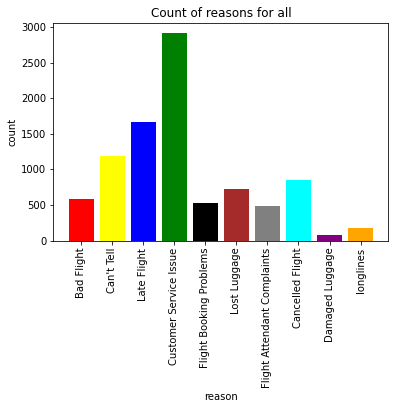

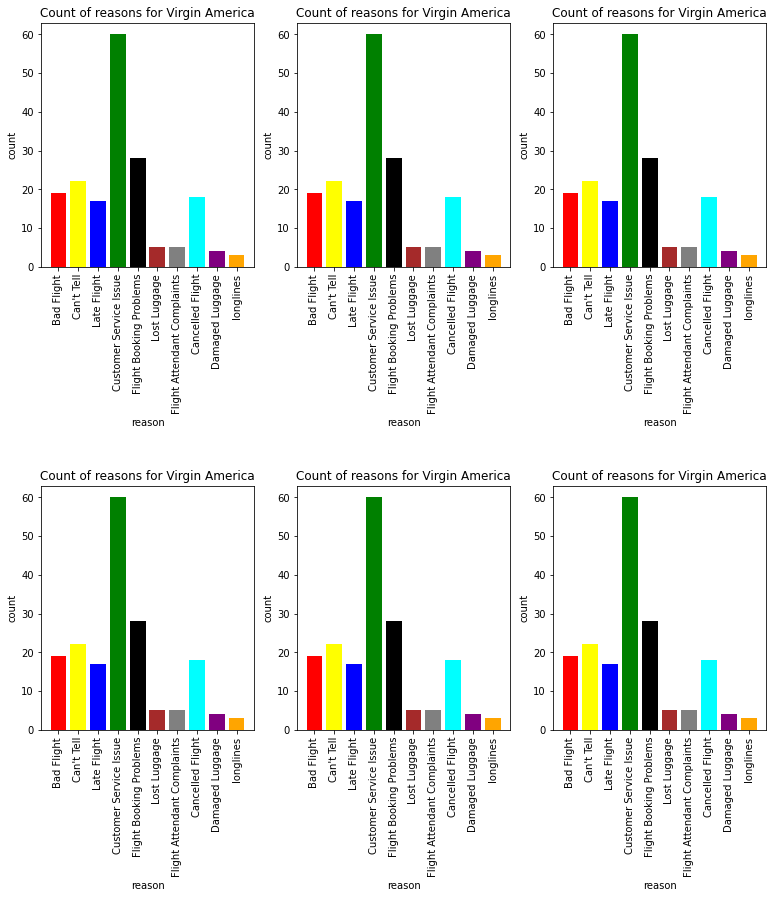

In [0]:
# Get more information about negative reasons


df["negativereason"].nunique()

nr_counts = dict(df["negativereason"].value_counts(sort=False))


def nr_count(airline):
    if airline == "all":
        a = df
    else:
        a = df[df["airline"] == airline]
    count = dict(a["negativereason"].value_counts())
    unique_reason = list(df["negativereason"].unique())
    unique_reason = [x for x in unique_reason if str(x) != "nan"]
    reason_frame = pd.DataFrame({"reasons": unique_reason})
    reason_frame["count"] = reason_frame["reasons"].apply(lambda x: count[x])
    return reason_frame


def plot_reason(airline):
    a = nr_count(airline)
    count = a["count"]
    idx = range(1, len(a)+1)
    colors = ["red", "yellow", "blue", 
              "green", "black", "brown", 
              "gray", "cyan", "purple", 
              "orange"]
    plt.bar(idx, count, color=colors)
    plt.xticks(idx, a["reasons"], rotation=90)
    plt.ylabel("count")
    plt.xlabel("reason")
    plt.title("Count of reasons for " + airline)


plot_reason("all")
plt.figure(2, figsize=(13, 13))

for airline in airlines:
    indices = airlines.index(airline)
    plt.subplot(2, 3, indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

#### 2.3 Dates-wise analysis

In [0]:
# Checking if there is any relationship between negative sentiments and date.


date = df.reset_index()

# convert date attr to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)

# only get the dates
date.tweet_created = date.tweet_created.dt.date

date.tweet_created.head()

df = date
day_df = df.groupby(["tweet_created", "airline", "airline_sentiment"]).size()

# This shows the sentiments of tweets for each date 
# from 2015-02-17 to 2015-02-24 for every airline in our dataframe.
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

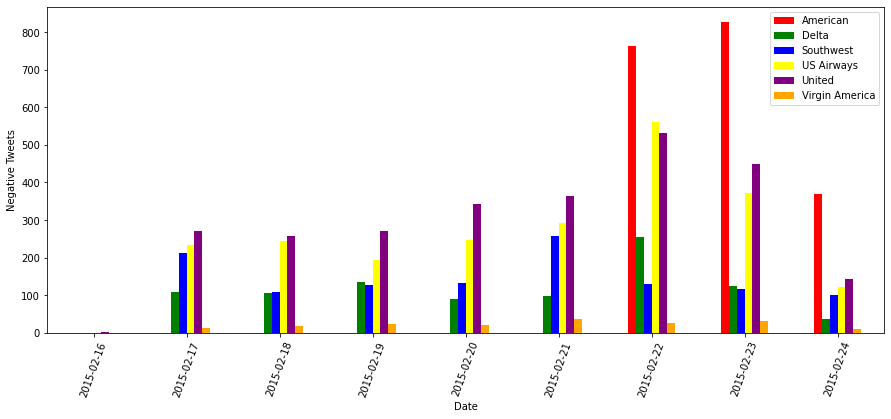

In [0]:
# plotting date wise visualisation


day_df = day_df.loc(axis=0)[:, :, "negative"]

# groupby and plot data
colors = ["red", "green", "blue", "yellow", "purple", "orange"]

ax2 = day_df.groupby(["tweet_created", "airline"]).sum().unstack().plot(kind="bar", 
                                                                        color=colors, 
                                                                        figsize=(15, 6), 
                                                                        rot=70)

labels = ["American", "Delta", "Southwest", "US Airways", "United", "Virgin America"]
ax2.legend(labels=labels)
ax2.set_xlabel("Date")
ax2.set_ylabel("Negative Tweets")
plt.show()

## 3. Preprocessing and classification

#### 3.1 Preprocess

In [0]:
# Preprocessing the tweet text data


def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [0]:
df["clean_tweet"] = df["text"].apply(lambda x: tweet_to_words(x))

In [0]:
# Split data for training and testing


train, test = train_test_split(df, test_size=0.2, random_state=106)

In [0]:
train_clean_tweet = []
for tweet in train["clean_tweet"]:
    train_clean_tweet.append(tweet)

test_clean_tweet = []
for tweet in test["clean_tweet"]:
    test_clean_tweet.append(tweet)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer="word")
train_features = v.fit_transform(train_clean_tweet)
test_features = v.transform(test_clean_tweet)

#### 3.2 Classify

In [0]:
# Defining classifiers


classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=200)]

Accuracy of DecisionTreeClassifier is 0.6851092896174863
              precision    recall  f1-score   support

    negative       0.78      0.80      0.79      1798
     neutral       0.47      0.41      0.44       676
    positive       0.59      0.63      0.61       454

    accuracy                           0.69      2928
   macro avg       0.61      0.61      0.61      2928
weighted avg       0.68      0.69      0.68      2928



<Figure size 432x288 with 0 Axes>

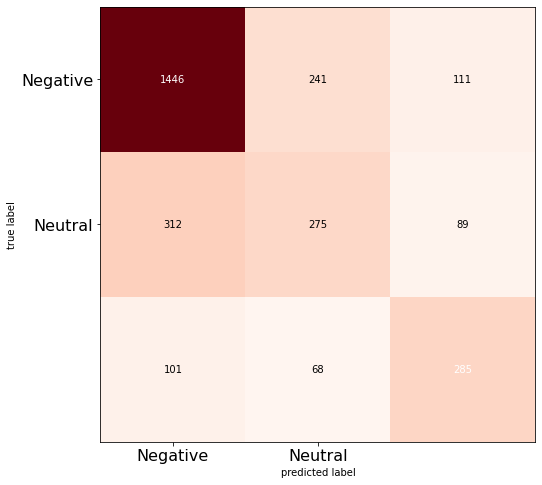

Accuracy of RandomForestClassifier is 0.7663934426229508
              precision    recall  f1-score   support

    negative       0.90      0.82      0.86      2048
     neutral       0.47      0.56      0.51       492
    positive       0.60      0.75      0.67       388

    accuracy                           0.77      2928
   macro avg       0.66      0.71      0.68      2928
weighted avg       0.79      0.77      0.77      2928



<Figure size 432x288 with 0 Axes>

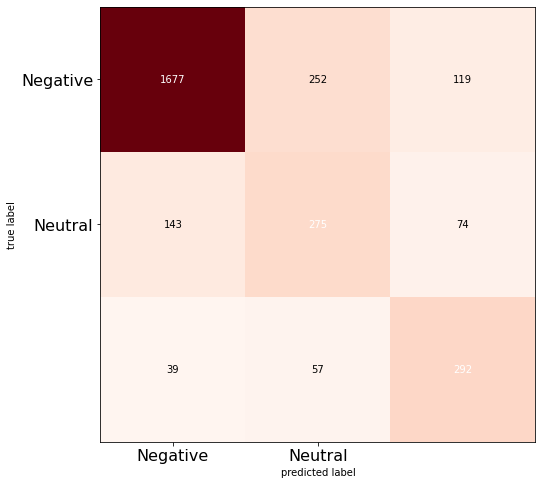

In [0]:
# fitting and predicting for the models


dense_features = train_features.toarray()
dense_test = test_features.toarray()
accuracies = []
models = []

for classifier in classifiers:
    try:
        fit = classifier.fit(train_features, train["airline_sentiment"])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(train_features, train["airline_sentiment"])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test["airline_sentiment"])
    accuracies.append(accuracy)
    models.append(classifier.__class__.__name__)
    print(f"Accuracy of {classifier.__class__.__name__} is {str(accuracy)}")
    print(classification_report(pred, test["airline_sentiment"]))
    cm = confusion_matrix(pred, test["airline_sentiment"])
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Reds)
    plt.xticks(range(2), ["Negative", "Neutral", "Positive"], fontsize=16, color='black')
    plt.yticks(range(2), ["Negative", "Neutral", "Positive"], fontsize=16)
    plt.show()
